In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# LangGraph Retrieval Agent

We can implement [Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) in [LangGraph](https://python.langchain.com/docs/langgraph).

## Retriever

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [7]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

tools = [tool]

from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Agent state
 
We will defined a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes and Edges

Each node will - 

1/ Either be a function or a runnable.

2/ Modify the `state`.

The edges choose which node to call next.

We can lay out an agentic RAG graph like this:

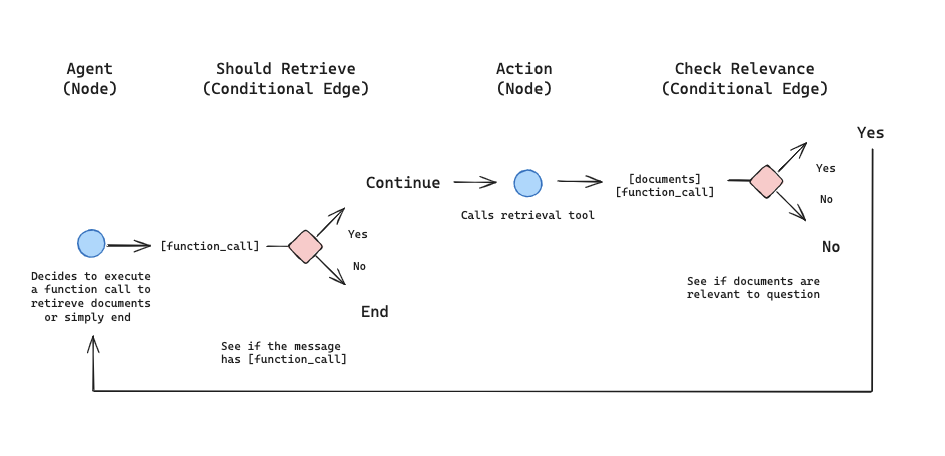

In [12]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation

### Edges


def should_retrieve(state):
    """
    Decides whether the agent should retrieve more information or end the process.

    This function checks the last message in the state for a function call. If a function call is
    present, the process continues to retrieve information. Otherwise, it ends the process.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        str: A decision to either "continue" the retrieval process or "end" it.
    """
    print("---DECIDE TO RETRIEVE---")
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # Otherwise there is a function call, so we continue
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"


def check_relevance(state):
    """
    Determines whether the Agent should continue based on the relevance of retrieved documents.

    This function checks if the last message in the conversation is of type FunctionMessage, indicating
    that document retrieval has been performed. It then evaluates the relevance of these documents to the user's
    initial question using a predefined model and output parser. If the documents are relevant, the conversation
    is considered complete. Otherwise, the retrieval process is continued.

    Args:
        state messages: The current state of the conversation, including all messages.

    Returns:
        str: A directive to either "end" the conversation if relevant documents are found, or "continue" the retrieval process.
    """

    print("---CHECK RELEVANCE---")

    # Output
    class FunctionOutput(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Create an instance of the PydanticOutputParser
    parser = PydanticOutputParser(pydantic_object=FunctionOutput)

    # Get the format instructions from the output parser
    format_instructions = parser.get_format_instructions()

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of retrieved docs to a user question. \n 
        Here are the retrieved docs:
        \n ------- \n
        {context} 
        \n ------- \n
        Here is the user question: {question}
        If the docs contain keyword(s) in the user question, then score them as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the docs are relevant to the question. \n 
        Output format instructions: \n {format_instructions}""",
        input_variables=["question"],
        partial_variables={"format_instructions": format_instructions},
    )

    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")

    chain = prompt | model | parser

    messages = state["messages"]
    last_message = messages[-1]
    score = chain.invoke(
        {"question": messages[0].content, "context": last_message.content}
    )

    # If relevant
    if score.binary_score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "yes"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score.binary_score)
        return "no"


### Nodes


# Define the function that calls the model
def call_model(state):
    """
    Invokes the agent model to generate a response based on the current state.

    This function calls the agent model to generate a response to the current conversation state.
    The response is added to the state's messages.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        dict: The updated state with the new message added to the list of messages.
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-0125-preview")
    functions = [format_tool_to_openai_function(t) for t in tools]
    model = model.bind_functions(functions)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    """
    Executes a tool based on the last message's function call.

    This function is responsible for executing a tool invocation based on the function call
    specified in the last message. The result from the tool execution is added to the conversation
    state as a new message.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        dict: The updated state with the new function message added to the list of messages.
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # print(type(response))
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [13]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", call_model)  # agent
workflow.add_node("action", call_tool)  # retrieval

In [14]:
# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    should_retrieve,
    {
        # Call tool node
        "continue": "action",
        "end": END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "action",
    # Assess agent decision
    check_relevance,
    {
        # Call agent node
        "yes": "agent",
        "no": END,  # placeholder
    },
)

# Compile
app = workflow.compile()

In [15]:
import pprint

from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="What are the types of agent memory based on Lilian Weng's blog post?"
        )
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"types of agent memory Lilian Weng"}', 'name': 'retrieve_blog_posts'}})]}
'\n---\n'
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
---EXECUTE RETRIEVAL---
"Output from node 'action':"
'---'
{ 'messages': [ FunctionMessage(content='Citation#\nCited as:\n\nWeng, Lilian. (Jun 2023). LLM-powered Autonomous Agents". Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nLLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\nThe design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave conditioned on pas

Trace:

https://smith.langchain.com/public/6f45c61b-69a0-4b35-bab9-679a8840a2d6/r